In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use('../style/plots.mplstyle')
mpl.rcParams['font.family'] = 'Liberation Sans'

In [3]:
path_data = os.path.join('..', '..', 'data')
path_rdm_individual = os.path.join('pickle', f'rdm_individual.pickle')
path_rdm_parallel = os.path.join('pickle', f'rdm_parallel.pickle')
path_rdm_all = os.path.join('pickle', f'rdm_task_switching.pickle')

In [4]:
path_figure = os.path.join('svg', 'figureS08c_shared_representations.svg')

In [5]:
with open(path_rdm_individual, 'rb') as handle:
    list_rdm_individual = pickle.load(handle)

with open(path_rdm_parallel, 'rb') as handle:
    list_rdm_parallel = pickle.load(handle)

with open(path_rdm_all, 'rb') as handle:
    list_rdm_all = pickle.load(handle)

In [6]:
num_inputs = 10

def calculate_representations(rdm_dict, num_inputs, num_tasks):
    layers = rdm_dict.keys()
    num_layers = len(layers)
    representations = {
        'self': np.zeros((num_layers, )),
        'shared': np.zeros((num_layers, ))
    }

    num_main_diag = num_tasks
    num_off_diag = (num_tasks  * (num_tasks - 1)) / 2
    block_elements = num_inputs ** 2

    for i_layer, layer in enumerate(layers):
        self_repr = _calculate_self_representations(rdm_dict[layer], num_inputs, num_tasks)
        shared_repr = _calculate_shared_representations(rdm_dict[layer], self_repr)

        normalized_self_repr = 2 * self_repr / (num_main_diag * block_elements)
        normalized_shared_repr = 2 * shared_repr / (num_off_diag * block_elements)

        representations['self'][i_layer] = normalized_self_repr
        representations['shared'][i_layer] = normalized_shared_repr
    
    return representations

def _calculate_shared_representations(rdm, self_repr):
    total_shared_repr = np.sum(np.abs(rdm - 0.5)) - self_repr
    return total_shared_repr / 2

def _calculate_self_representations(rdm, num_inputs, num_tasks):
    total_self_repr = 0
    for i in range(num_tasks):
        start = i * num_inputs
        total_self_repr += np.sum(np.abs(rdm[start:start+num_inputs,
                                                   start:start+num_inputs] - 0.5)) 

    return total_self_repr

In [7]:
assert len(list_rdm_individual) == len(list_rdm_parallel) == len(list_rdm_all)
assert len(list_rdm_individual[0]) == len(list_rdm_parallel[0]) == len(list_rdm_all[0])
assert len(list_rdm_individual[0][1]) == len(list_rdm_parallel[0][1]) == len(list_rdm_all[0][1])
assert len(list_rdm_individual[0][1]) % num_inputs == 0

num_seeds = len(list_rdm_individual)
num_layers = len(list_rdm_individual[0])
num_tasks = len(list_rdm_individual[0][1]) // num_inputs

print(f'Num. Seeds: {num_seeds}')
print(f'Num. Layers: {num_layers}')
print(f'Num. Tasks: {num_tasks}')

Num. Seeds: 10
Num. Layers: 5
Num. Tasks: 5


In [8]:
shared_individual = np.zeros((num_seeds, num_layers))
shared_parallel = np.zeros((num_seeds, num_layers))
shared_all = np.zeros((num_seeds, num_layers))

self_individual = np.zeros((num_seeds, num_layers))
self_parallel = np.zeros((num_seeds, num_layers))
self_all = np.zeros((num_seeds, num_layers))

In [9]:
for i_seed, seed in enumerate(range(num_seeds)):
    dict_seed_individual = calculate_representations(list_rdm_individual[i_seed], num_inputs, num_tasks)
    dict_seed_parallel = calculate_representations(list_rdm_parallel[i_seed], num_inputs, num_tasks)
    dict_seed_all = calculate_representations(list_rdm_all[i_seed], num_inputs, num_tasks)

    shared_individual[i_seed, :] = dict_seed_individual['shared']
    shared_parallel[i_seed, :] = dict_seed_parallel['shared']
    shared_all[i_seed, :] = dict_seed_all['shared']

    self_individual[i_seed, :] = dict_seed_individual['self']
    self_parallel[i_seed, :] = dict_seed_parallel['self']
    self_all[i_seed, :] = dict_seed_all['self']

In [10]:
df_results_shared = pd.DataFrame({}, columns=['Model', 'Layer', 'Representations'])

for i_seed, seed in enumerate(range(num_seeds)):
    for j_layer, layer in enumerate(range(num_layers)):
        df_results_individual = pd.DataFrame({'Model': ['Sequential'], 'Layer': [layer + 1], 'Representations': [100 * shared_individual[i_seed, j_layer]]})
        df_results_parallel = pd.DataFrame({'Model': ['Parallel'], 'Layer': [layer + 1], 'Representations': [100 * shared_parallel[i_seed, j_layer]]})
        df_results_ts = pd.DataFrame({'Model': ['Task-Switching'], 'Layer': [layer + 1], 'Representations': [100 * shared_all[i_seed, j_layer]]})

        df_results_shared = pd.concat((df_results_shared, df_results_individual, df_results_parallel, df_results_ts))        
df_results_shared.reset_index(inplace=True, drop=True)

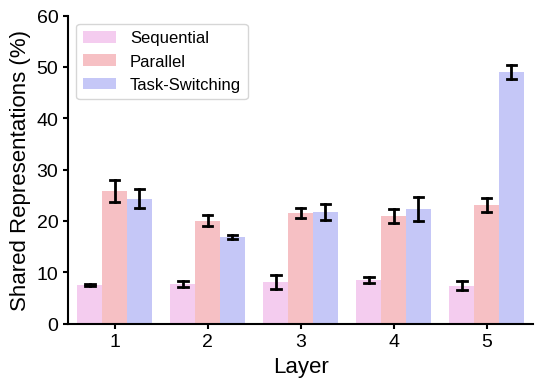

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

barplot = sns.barplot(x='Layer',
                      y='Representations',
                      hue='Model',
                      data=df_results_shared,
                      errorbar='sd',
                      ax=ax, errwidth=2,
                      capsize=0.1,
                      zorder=-1,
                      errcolor='k',
                      error_kw={'zorder': 10})
"""
sns.stripplot(x='Layer',
              y='Representations',
              hue='Model',
              data=df_results_shared,
              ax=ax,
              dodge=True,
              ec='k',
              linewidth=1,
              zorder=1,
              edgecolor='k',
              alpha=0.4)
"""

plt.ylabel('Shared Representations (%)', fontsize=16)
plt.xlabel('Layer', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 60)
plt.gca().lines[-1].set_zorder(10)

# handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper left')
fig.savefig(path_figure,
            transparent=True,
            bbox_inches='tight')
plt.show()